In [1]:
import os
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from PIL import Image, ImageEnhance

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


In [2]:
data_path = r"<directory to data folder>" 

images = []
labels = []

for subfolder in os.listdir(data_path):
    
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
data = pd.DataFrame({'image': images, 'label': labels})

In [3]:
# Function to perform color correction
def image_enhancement(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Convert color if necessary
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Color Correction
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)
    limg = cv2.merge((cl, a_channel, b_channel))
    corrected_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    # Contrast enhancement
    pil_image = Image.fromarray(corrected_image)
    enhancer = ImageEnhance.Contrast(pil_image)
    enhanced_image = enhancer.enhance(1.5)  # Enhance contrast by a factor of 1.5

    # Convert back to numpy array (RGB)
    final_image = np.array(enhanced_image)

    # Pad the image to make it square
    final_image = pad_to_square(final_image)
    
    # Resize image to target size
    img_size = (256, 256)
    resized_image = cv2.resize(final_image, img_size)
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR)
    
    return resized_image

# Function to add padding to the image to make it square
def pad_to_square(image):
    height, width, _ = image.shape
    max_dim = max(height, width)
    top = (max_dim - height) // 2
    bottom = max_dim - height - top
    left = (max_dim - width) // 2
    right = max_dim - width - left
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

In [4]:
def canny_edge_detector(enhanced_image):
    # Perform Canny Edge Detector
    edged = cv2.Canny(enhanced_image, threshold1=50, threshold2=150)
    
    return edged

In [5]:
def create_mask(edged_image):
    # Create a mask where the edges are white and the rest is black
    mask = np.zeros_like(edged_image)
    mask[edged_image > 0] = 255
    
    return mask

In [6]:
def apply_mask(image, mask):
    # Apply the mask to the enhanced image
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    return masked_image

In [7]:
procImg = []

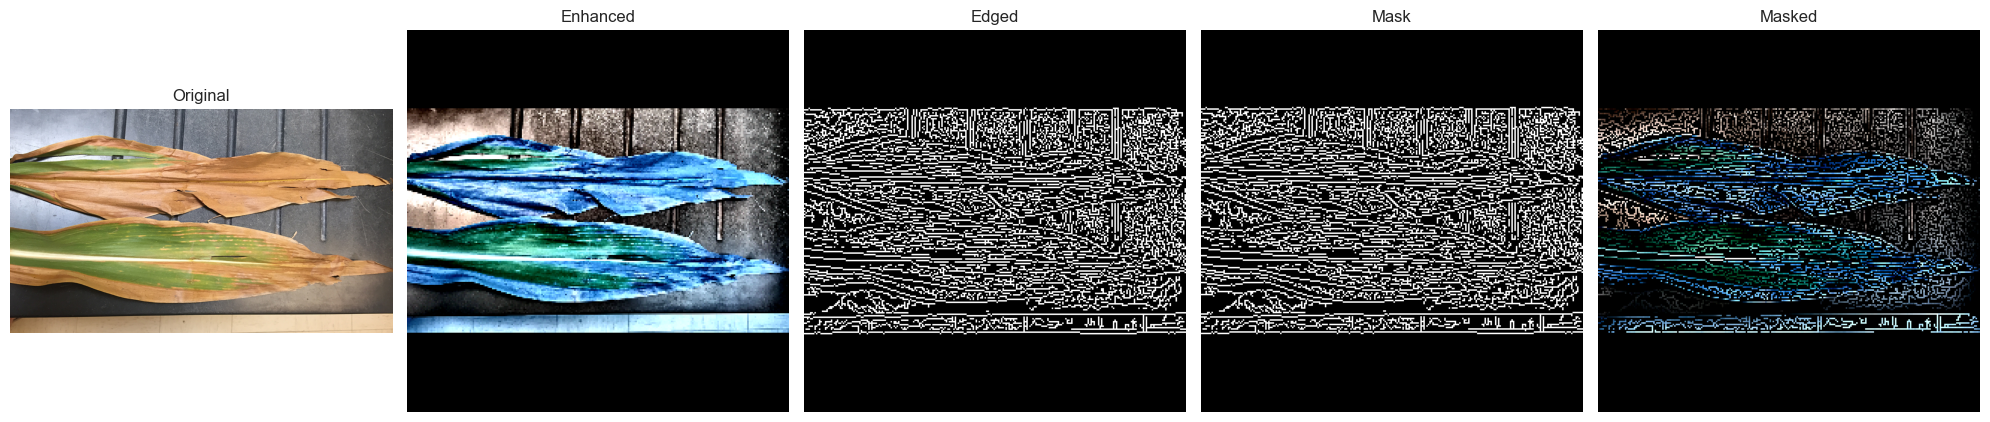

In [8]:
# Process all images and show one example
for index, row in data.iterrows():
    # Original image
    original_image = row['image']

    # Enhanced image
    enhanced_image = image_enhancement(original_image)

    # Canny Edged image
    canny_edged_image = canny_edge_detector(enhanced_image)

    # Mask
    mask = create_mask(canny_edged_image)

    # Masked image
    masked_image = apply_mask(enhanced_image, mask)

    # Append masked image to list
    procImg.append(masked_image)

    image = cv2.imread(original_image)
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display example of processed images for the first index
    if index == 0:
        fig, axs = plt.subplots(1, 5, figsize=(20, 10))

        # Titles for each image display
        titles = ["Original", "Enhanced", "Edged", "Mask", "Masked"]

        # Display each image with its corresponding title
        axs[0].imshow(original_image)
        axs[0].set_title(titles[0])
        axs[0].axis("off")

        axs[1].imshow(enhanced_image)
        axs[1].set_title(titles[1])
        axs[1].axis("off")

        axs[2].imshow(canny_edged_image, cmap='gray')
        axs[2].set_title(titles[2])
        axs[2].axis("off")

        axs[3].imshow(mask, cmap='gray')
        axs[3].set_title(titles[3])
        axs[3].axis("off")

        axs[4].imshow(masked_image)
        axs[4].set_title(titles[4])
        axs[4].axis("off")

        plt.tight_layout()
        plt.show()

In [9]:
# Assuming procImg is your list of processed images from the previous part
for index in range(len(procImg)):
    image = procImg[index]
    imageRGB = image
    
    # Define the base directory to save processed images
    base_output_dir = r"<directory to masked_image folder>"

    # Create the base output directory if it doesn't exist
    os.makedirs(base_output_dir, exist_ok=True)
    
    label = data.loc[index, 'label']
    label_dir = os.path.join(base_output_dir, label)
    
    # Create subdirectory for the label if it doesn't exist
    os.makedirs(label_dir, exist_ok=True)
    
    # Generate filename based on index
    filename = f"leaf_{index}.jpg"
    filepath = os.path.join(label_dir, filename)
    
    # Save the leaf image
    cv2.imwrite(filepath, cv2.cvtColor(imageRGB, cv2.COLOR_RGB2BGR))

print("Leaf masked image saving process completed.")

Leaf masked image saving process completed.


In [10]:
# split

In [10]:
# Define the base directory where processed images are saved
base_output_dir = r"<directory to masked_image folder>"

# Initialize lists to store image paths and labels
images = []
labels = []

# Iterate through each label folder in the base output directory
for label in os.listdir(base_output_dir):
    label_dir = os.path.join(base_output_dir, label)
    
    if os.path.isdir(label_dir):
        # Iterate through each image file in the label folder
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                # Construct the image path
                image_path = os.path.join(label_dir, filename)
                images.append(image_path)
                labels.append(label)

# Create a DataFrame from the collected image paths and labels
data = pd.DataFrame({'image': images, 'label': labels})

# Split the dataset into train (85%), validation (7.5%), and test (7.5%) sets
strat = data['label']
train_df, temp_df = train_test_split(data, train_size=0.85, shuffle=True, random_state=123, stratify=strat)
strat = temp_df['label']
valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

# Optionally, reset the index for each dataframe
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Display the sizes of each dataset (optional)
print(f"Number of samples in train set: {len(train_df)}")
print(f"Number of samples in validation set: {len(valid_df)}")
print(f"Number of samples in test set: {len(test_df)}")

Number of samples in train set: 3559
Number of samples in validation set: 314
Number of samples in test set: 315


In [11]:
# Define image generator parameters
batch_size = 32
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Initialize ImageDataGenerators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Create data generators
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True,
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True,
                                       batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False,
                                      batch_size=batch_size)

Found 3559 validated image filenames belonging to 4 classes.
Found 314 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.


In [13]:
# Data Visualization

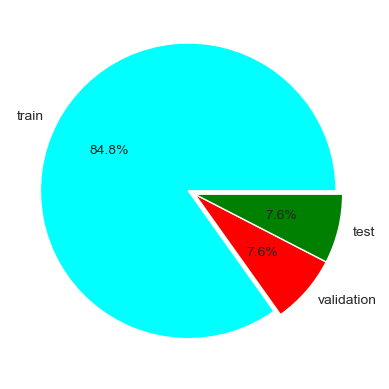

<Figure size 640x480 with 0 Axes>

In [12]:
plt.pie([len(train_gen), len(valid_gen), len(test_gen)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['aqua', 'red', 'green'], explode=(0.05, 0, 0))
plt.show()
plt.savefig('dataset_pie.png')

In [13]:
print(train_gen.class_indices)
print(test_gen.class_indices)
print(valid_gen.class_indices)

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


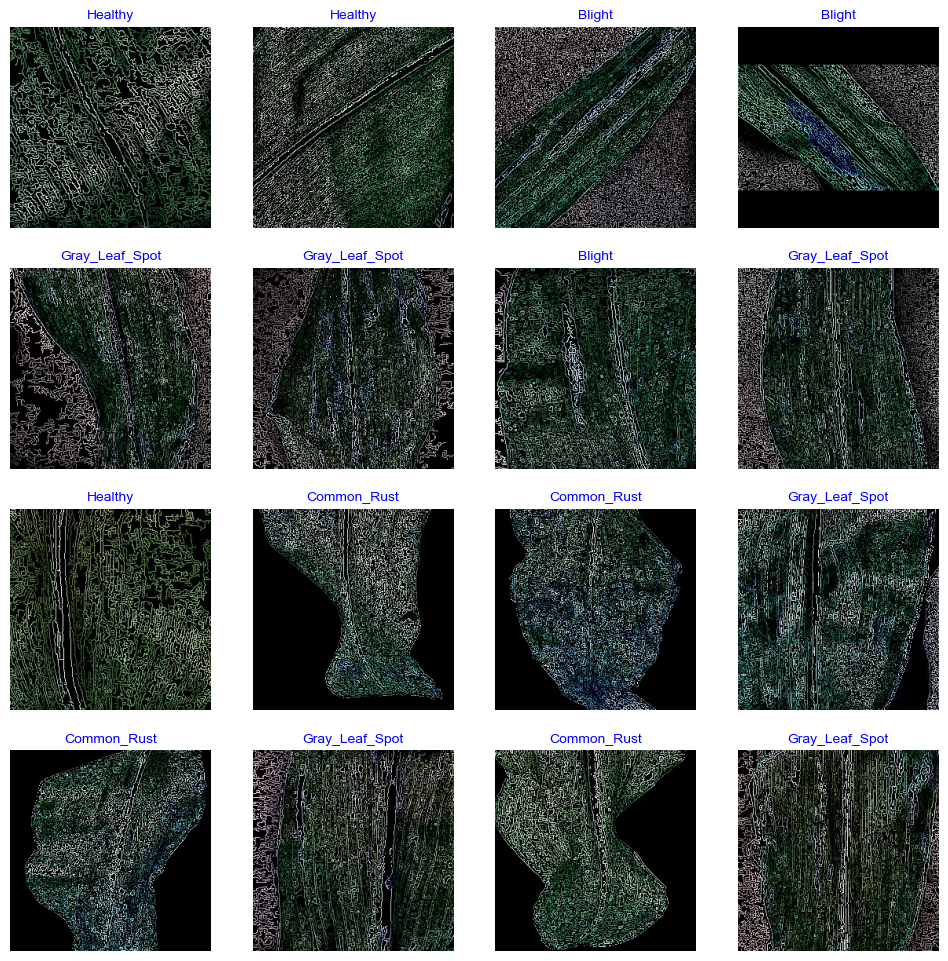

In [14]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

In [17]:
# CNN model

In [15]:
from tensorflow.keras import models, layers

n_classes = 4
input_shape = (256, 256, 3)  

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='Conv1'),
    layers.MaxPooling2D((2, 2), name='MaxPool1'),
    layers.Conv2D(64, (3, 3), activation='relu', name='Conv2'),
    layers.MaxPooling2D((2, 2), name='MaxPool2'),
    layers.Conv2D(64, (3, 3), activation='relu', name='Conv3'),
    layers.MaxPooling2D((2, 2), name='MaxPool3'),
    layers.Conv2D(64, (3, 3), activation='relu', name='Conv4'),
    layers.MaxPooling2D((2, 2), name='MaxPool4'),
    layers.Flatten(name='Flatten'),
    layers.Dense(64, activation='relu', name='Dense1'),
    layers.Dense(n_classes, activation='softmax', name='Output')
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 254, 254, 32)      896       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 127, 127, 32)      0         
                                                                 
 Conv2 (Conv2D)              (None, 125, 125, 64)      18496     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 62, 62, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 60, 60, 64)        36928     
                                                                 
 MaxPool3 (MaxPooling2D)     (None, 30, 30, 64)        0         
                                                                 
 Conv4 (Conv2D)              (None, 28, 28, 64)       

In [19]:
# Callback and Model Compile

In [16]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=4,
    batch_size=32,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[callbacks]
)

Epoch 1/4


112/112 [==============================] - 118s 1s/step - loss: 6.4291 - accuracy: 0.5325 - val_loss: 0.8125 - val_accuracy: 0.6688
Epoch 2/4
112/112 [==============================] - 112s 998ms/step - loss: 0.6593 - accuracy: 0.7283 - val_loss: 0.6946 - val_accuracy: 0.7102
Epoch 3/4
112/112 [==============================] - 110s 979ms/step - loss: 0.4369 - accuracy: 0.8331 - val_loss: 0.6975 - val_accuracy: 0.7229
Epoch 4/4
112/112 [==============================] - 115s 1s/step - loss: 0.3109 - accuracy: 0.8837 - val_loss: 0.5774 - val_accuracy: 0.7930


In [21]:
# Accuracy and Loss Curve

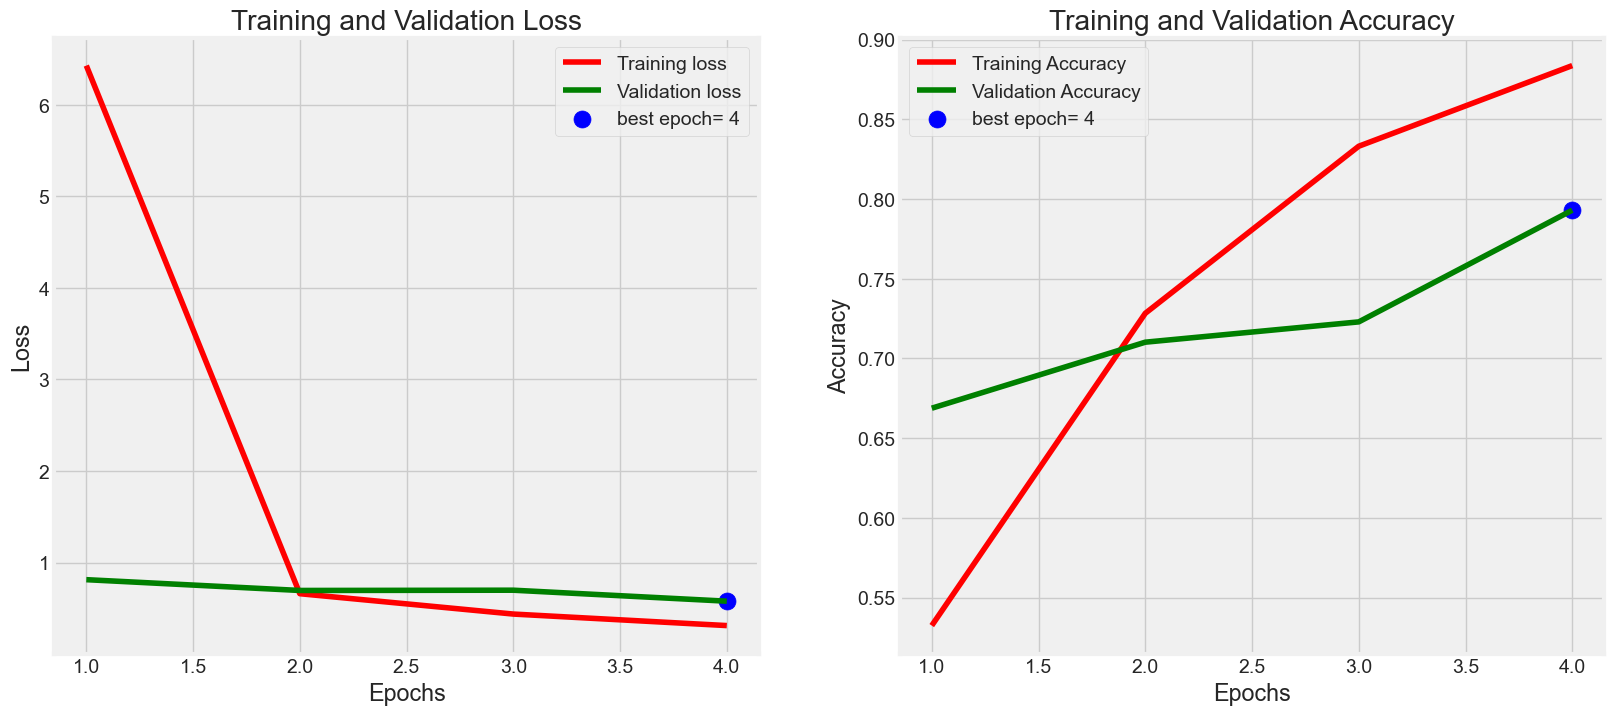

In [17]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [23]:
# Accuracy score

In [18]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

10/10 [==============================] - 3s 267ms/step - loss: 0.5774 - accuracy: 0.7930
Accuracy score: 0.7929936051368713


In [19]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 2s 291ms/step - loss: 0.5949 - accuracy: 0.7875
Train Loss:  0.18988288938999176
Train Accuracy:  0.9750000238418579
--------------------
Valid Loss:  0.5419491529464722
Valid Accuracy:  0.8125
--------------------
Test Loss:  0.5948681831359863
Test Accuracy:  0.7875000238418579


In [26]:
# Classification Report

In [20]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

10/10 [==============================] - 3s 269ms/step


In [21]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                precision    recall  f1-score   support

        Blight       0.63      0.81      0.71        86
   Common_Rust       0.96      0.95      0.95        98
Gray_Leaf_Spot       0.54      0.35      0.42        43
       Healthy       0.87      0.78      0.83        88

      accuracy                           0.78       315
     macro avg       0.75      0.72      0.73       315
  weighted avg       0.79      0.78      0.78       315



In [29]:
# Confusion Matrix

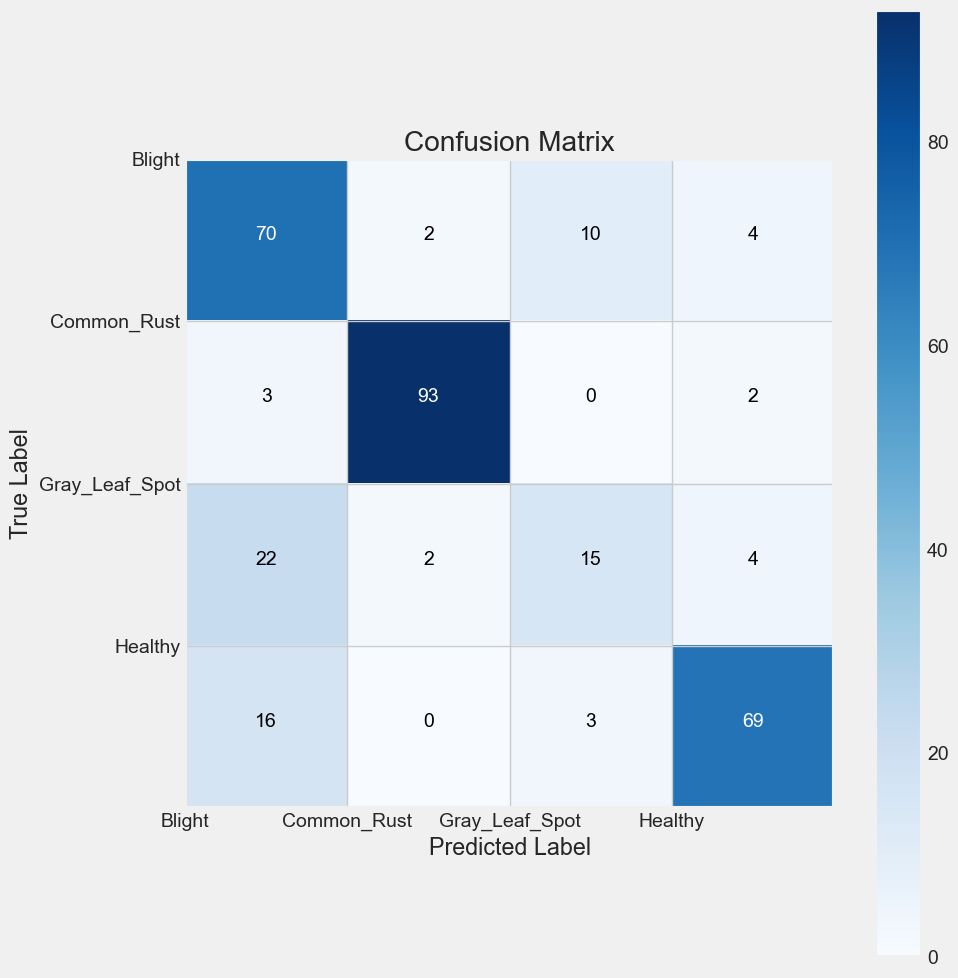

In [22]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)  
plt.yticks(tick_marks - 0.5, classes) 


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [31]:
# Model Save

In [23]:
model.save('modelCannyEdge.h5')

In [33]:
# Model Prediction App

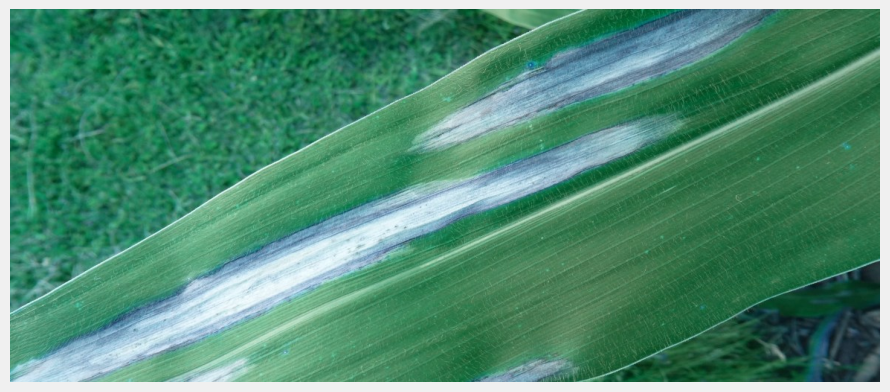

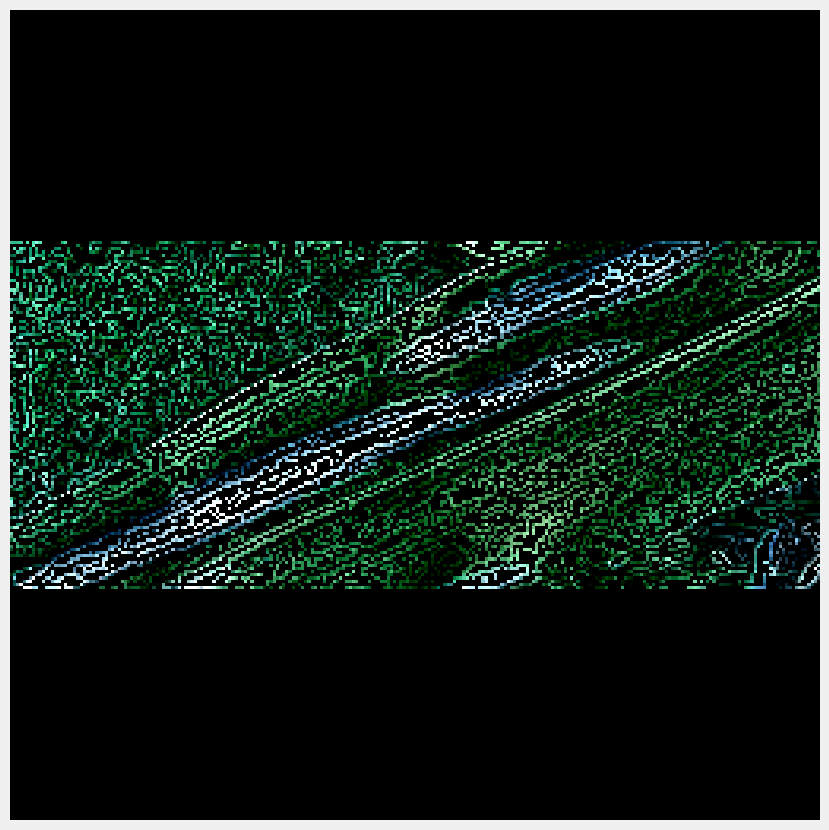

1/1 [==============================] - 0s 200ms/step
Predicted label: blight


In [28]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image, ImageEnhance

# Load your trained model
model_path = 'modelCannyEdge.h5'  # Update with your model path
model = load_model(model_path)

# Function to perform color correction
def image_enhancement(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Convert color if necessary
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Color Correction
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)
    limg = cv2.merge((cl, a_channel, b_channel))
    corrected_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    # Contrast enhancement
    pil_image = Image.fromarray(corrected_image)
    enhancer = ImageEnhance.Contrast(pil_image)
    enhanced_image = enhancer.enhance(1.5)  # Enhance contrast by a factor of 1.5

    # Convert back to numpy array (RGB)
    final_image = np.array(enhanced_image)

    # Pad the image to make it square
    final_image = pad_to_square(final_image)
    
    # Resize image to target size
    img_size = (256, 256)
    resized_image = cv2.resize(final_image, img_size)
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR)
    return resized_image

# Function to add padding to the image to make it square
def pad_to_square(image):
    height, width, _ = image.shape
    max_dim = max(height, width)
    top = (max_dim - height) // 2
    bottom = max_dim - height - top
    left = (max_dim - width) // 2
    right = max_dim - width - left
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

def canny_edge_detector(enhanced_image):
    # Perform Canny Edge Detector
    edged = cv2.Canny(enhanced_image, threshold1=50, threshold2=150)
    return edged

def create_mask(edged_image):
    # Create a mask where the edges are white and the rest is black
    mask = np.zeros_like(edged_image)
    mask[edged_image > 0] = 255
    return mask

def apply_mask(image, mask):
    # Apply the mask to the enhanced image
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    return masked_image

# Function to predict using the loaded model
def predict_image(image_path, model):
    
    # Enhanced image
    enhanced_image = image_enhancement(image_path)

    # Canny Edged image
    canny_edged_image = canny_edge_detector(enhanced_image)

    # Mask
    mask = create_mask(canny_edged_image)

    # Masked image
    masked_image = apply_mask(enhanced_image, mask)

    plt.figure(figsize=(10, 10))
    plt.imshow(masked_image)
    plt.axis("off")
    plt.show()
    
    # Make prediction
    prediction = model.predict(np.expand_dims(masked_image, axis=0))
    
    # Extract the predicted class label
    predicted_class = np.argmax(prediction, axis=-1)
    
    return predicted_class

# Example usage:
image_path = r"<directory to specific image>"  # Update with your image path
# Load image again for display
image_display = cv2.imread(image_path)
    
# Display the input image
plt.figure(figsize=(10, 10))
plt.imshow(image_display)
plt.axis("off")
plt.show()
predicted_class = predict_image(image_path, model)

# Display the predicted class label (assuming you have a mapping from classes to labels)
class_labels = {0: 'blight', 1: 'common_rust', 2: 'gray_leaf_spot', 3: 'healthy'}  # Update with your class labels
predicted_label = class_labels[predicted_class[0]]
print(f"Predicted label: {predicted_label}")
